In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [4]:
test_data_size=1000
test_frac = 0.1
input_size = 18
output_size = 8

input_size: 2 sets of 8 subjects + 2 indicators for activities
output_size: 8 subject grades

In [5]:
def scoremaker():
    #empty scores represent the subjects that the student doesn't take
    emptyScores = np.random.randint(low = 0, high = output_size, size=(3))        
    
    #randomly generate 2 sets of results. For different schools, scale the result accordingly
    scores = np.random.randint(low = 50, high = 90, size=(output_size))
    scores = scores + np.random.randint(low = -10, high = 10, size=(output_size))
    scores2 = np.random.randint(low = 50, high = 90, size=(output_size))
    scores2 = scores2 + np.random.randint(low = -10, high = 10, size=(output_size))
    
    #generate 2 values, 1 for humanities-related activities and one for science activities. More activities = higher score
    activities = np.random.randint(low = 0, high = 10, size = (2))
    
    #generate fake labels for each listing.
    scoreLabels = (scores + scores2) / 2
    
    #add activity score to labels for each subject
    for i in range(output_size):
        if(i < 4): scoreLabels[i] += activities[0]
        else: scoreLabels[i] += activities[1]

    scoreLabels = (scoreLabels - 40) / 60
    
    #make subjects empty
    for i in emptyScores:
        scores[i] = 0
        scores2[i] = 0
        scoreLabels[i] = 0
        
    return np.concatenate((scores, scores2, activities, scoreLabels))

In [6]:
scoremaker()

array([92.        , 69.        , 72.        , 65.        ,  0.        ,
        0.        , 73.        ,  0.        , 88.        , 74.        ,
       58.        , 65.        ,  0.        ,  0.        , 83.        ,
        0.        ,  6.        ,  2.        ,  0.93333333,  0.625     ,
        0.51666667,  0.51666667,  0.        ,  0.        ,  0.66666667,
        0.        ])

In [7]:
my_data = np.array([scoremaker() for i in range(test_data_size)])

In [9]:
print(my_data[:10])

[[41.          0.         69.         55.         62.         83.
   0.         45.         70.          0.         82.         88.
  62.         83.          0.         68.          7.          6.
   0.375       0.          0.70833333  0.64166667  0.46666667  0.81666667
   0.          0.375     ]
 [50.         89.          0.         75.         57.          0.
   0.         61.         79.         94.          0.         54.
  73.          0.          0.         86.          5.          3.
   0.49166667  0.94166667  0.          0.49166667  0.46666667  0.
   0.          0.60833333]
 [84.         70.          0.         64.         70.          0.
  76.         88.         90.         46.          0.         82.
  61.          0.         89.         47.          8.          5.
   0.91666667  0.43333333  0.          0.68333333  0.50833333  0.
   0.79166667  0.54166667]
 [ 0.         86.         52.          0.         77.          0.
  84.         84.          0.         76.         75.

In [87]:
# inputs = keras.Input(shape=(input_size,), name="subjects")
# x = layers.Dense(20,activation='relu', name='Hidden1') (inputs)
# x = layers.Dense(20,activation='relu', name='Hidden2') (x)
# outputs = layers.Dense(output_size, activation="relu", name="predictions")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

In [88]:
model = keras.Sequential()
model.add(keras.Input(shape=(input_size,), name="inputs"))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(output_size, activation="relu", name="predictions"))

In [89]:
x_train = my_data[:,:input_size]

x_train = (x_train - np.average(x_train, axis = 0))/np.std(x_train, axis = 0)

y_train = my_data[:,input_size:]
x_val = x_train[(int)((1-test_frac)*test_data_size):]
y_val = y_train[(int)((1-test_frac)*test_data_size):]
x_train = x_train[:(int)((1-test_frac)*test_data_size)]
y_train = y_train[:(int)((1-test_frac)*test_data_size)]

In [90]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.mean_squared_error,
    metrics = [keras.metrics.mean_squared_error]
)

In [91]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/100
15/15 [==============================] - 0s 6ms/step - loss: 0.2872 - mean_squared_error: 0.2872 - val_loss: 0.2668 - val_mean_squared_error: 0.2668
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 0.2167 - mean_squared_error: 0.2167 - val_loss: 0.2058 - val_mean_squared_error: 0.2058
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.1783 - mean_squared_error: 0.1783 - val_loss: 0.1710 - val_mean_squared_error: 0.1710
Epoch 4/100
15/15 [==============================] - 0s 1ms/step - loss: 0.1545 - mean_squared_error: 0.1545 - val_loss: 0.1481 - val_mean_squared_error: 0.1481
Epoch 5/100
15/15 [==============================] - 0s 1ms/step - loss: 0.1381 - mean_squared_error: 0.1381 - val_loss: 0.1309 - val_mean_squared_error: 0.1309
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 0.1249 - mean_squared_error: 0.1249 - val_loss: 0.1182 - val_mean_squared_error: 0.1182
Epoch 7

In [92]:
history.history
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

In [93]:
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()  

    print("Defined the plot_the_loss_curve function.")

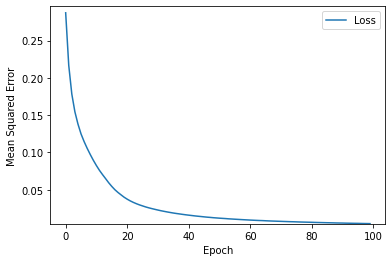

Defined the plot_the_loss_curve function.


In [94]:
plot_the_loss_curve(epochs, mse)

In [95]:
predictions = model.predict(x_train[:10])
for i in range(10):
    print(predictions[i])
    print(y_train[i])

[0.31401446 0.         0.         0.45950034 0.540447   0.63565356
 0.61115944 0.53607637]
[0.15833333 0.         0.         0.48333333 0.60833333 0.56666667
 0.80833333 0.51666667]
[0.         0.9177028  0.31202215 0.50239664 0.4934757  0.36134768
 0.         0.5702154 ]
[0.         0.9        0.43333333 0.625      0.56666667 0.18333333
 0.         0.60833333]
[0.         0.5332006  0.72556037 0.32545218 0.49615684 0.61015373
 0.83832407 0.        ]
[0.         0.53333333 0.88333333 0.44166667 0.475      0.59166667
 0.875      0.        ]
[0.42654175 0.         0.45410335 0.42028156 0.39796433 0.
 0.         0.30291238]
[0.50833333 0.         0.35833333 0.49166667 0.39166667 0.
 0.         0.15833333]
[0.33918774 0.58686817 0.58670795 0.56240326 0.41371548 0.
 0.01075658 0.        ]
[0.43333333 0.63333333 0.54166667 0.65833333 0.475      0.
 0.         0.        ]
[0.45799    0.5626334  0.         0.5275641  0.22353116 0.
 0.00739394 0.46210116]
[0.4        0.575      0.         0.525

In [96]:
model.save("gradeModel.h5")

In [97]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('gradeModel.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\leeji\AppData\Local\Temp\tmpu41l4plm\assets
